# Relative Strength Index, On-Balance Volume & Bollinger Bands

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# yahoo finance is used to fetch data 
import yfinance as yf
yf.pdr_override()

In [2]:
# input
symbol = 'AAPL'
start = '2018-08-01'
end = '2019-01-01'

# Read data 
df = yf.download(symbol,start,end)

# View Columns
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-01,49.782501,50.439999,49.327499,50.375000,48.500771,271742800
2018-08-02,50.145000,52.095001,50.087502,51.847500,49.918476,249616000
2018-08-03,51.757500,52.185001,51.369999,51.997501,50.062901,133789600
2018-08-06,52.000000,52.312500,51.767502,52.267502,50.322861,101701600
2018-08-07,52.330002,52.375000,51.689999,51.777500,49.851089,102349600


In [3]:
n = 14 # Number of period

MA = pd.Series(df['Adj Close'].rolling(n).mean())
STD = pd.Series(df['Adj Close'].rolling(n).std())
bb1 = MA + 2*STD
df['Upper Bollinger Band'] = pd.Series(bb1)
bb2 = MA - 2*STD
df['Lower Bollinger Band'] = pd.Series(bb2)

change = df['Adj Close'].diff(1)
df['Gain'] = change.mask(change<0,0)
df['Loss'] = abs(change.mask(change>0,0))
df['AVG_Gain'] = df.Gain.rolling(n).mean()
df['AVG_Loss'] = df.Loss.rolling(n).mean()
df['RS'] = df['AVG_Gain']/df['AVG_Loss']
df['RSI'] = 100 - (100/(1+df['RS']))

df['PC'] = df['Close'].shift()
df['P/N'] = np.where(df['Close'] > df['PC'] , df['Volume'] , -df['Volume']) 
df['OBV'] = np.cumsum(np.array(df['P/N']))

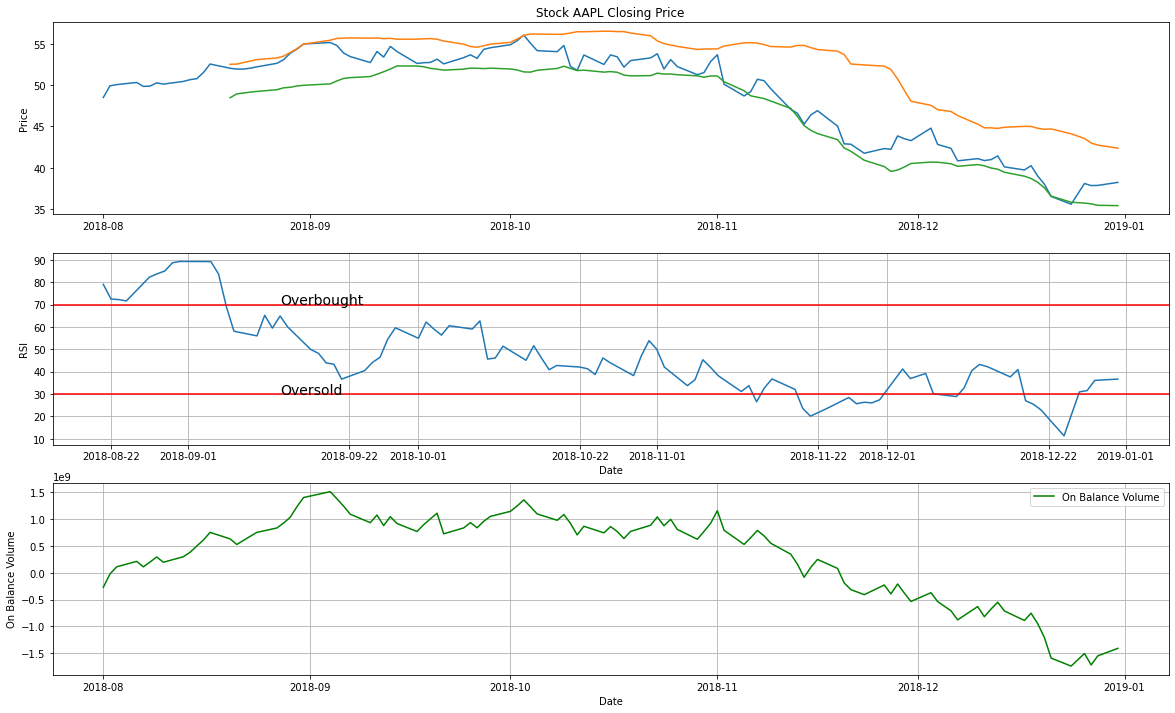

In [4]:
fig = plt.figure(figsize=(20,12))
ax1 = plt.subplot(3, 1, 1)
ax1.plot(df[['Adj Close', 'Upper Bollinger Band','Lower Bollinger Band']])
ax1.set_title('Stock '+ symbol +' Closing Price')
ax1.set_ylabel('Price')

ax2 = plt.subplot(3, 1, 2)
ax2.plot(df['RSI'], label='Relative Strengths Index')
ax2.text(s='Overbought', x=df.RSI.index[30], y=70, fontsize=14)
ax2.text(s='Oversold', x=df.RSI.index[30], y=30, fontsize=14)
ax2.axhline(y=70, color='red')
ax2.axhline(y=30, color='red')
ax2.grid()
ax2.set_ylabel('RSI')
ax2.set_xlabel('Date')

ax3 = plt.subplot(3, 1, 3)
ax3.plot(df['OBV'], label='On Balance Volume', color='green')
ax3.grid()
ax3.set_ylabel('On Balance Volume')
ax3.set_xlabel('Date')
ax3.legend(loc='best')

# Candlestick with RSI, OBV & BB

In [5]:
from matplotlib import dates as mdates
import datetime as dt

dfc = df.copy()
dfc['VolumePositive'] = dfc['Open'] < dfc['Adj Close']
#dfc = dfc.dropna()
dfc = dfc.reset_index()
dfc['Date'] = pd.to_datetime(dfc['Date'])
dfc['Date'] = dfc['Date'].apply(mdates.date2num)
dfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Upper Bollinger Band,Lower Bollinger Band,Gain,Loss,AVG_Gain,AVG_Loss,RS,RSI,PC,P/N,OBV,VolumePositive
0,17744.0,49.782501,50.439999,49.327499,50.375000,48.500771,271742800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-271742800,-271742800,False
1,17745.0,50.145000,52.095001,50.087502,51.847500,49.918476,249616000,NaN,NaN,1.417706,0.000000,NaN,NaN,NaN,NaN,50.375000,249616000,-22126800,False
2,17746.0,51.757500,52.185001,51.369999,51.997501,50.062901,133789600,NaN,NaN,0.144424,0.000000,NaN,NaN,NaN,NaN,51.847500,133789600,111662800,False
3,17749.0,52.000000,52.312500,51.767502,52.267502,50.322861,101701600,NaN,NaN,0.259960,0.000000,NaN,NaN,NaN,NaN,51.997501,101701600,213364400,False
4,17750.0,52.330002,52.375000,51.689999,51.777500,49.851089,102349600,NaN,NaN,0.000000,0.471771,NaN,NaN,NaN,NaN,52.267502,-102349600,111014800,False


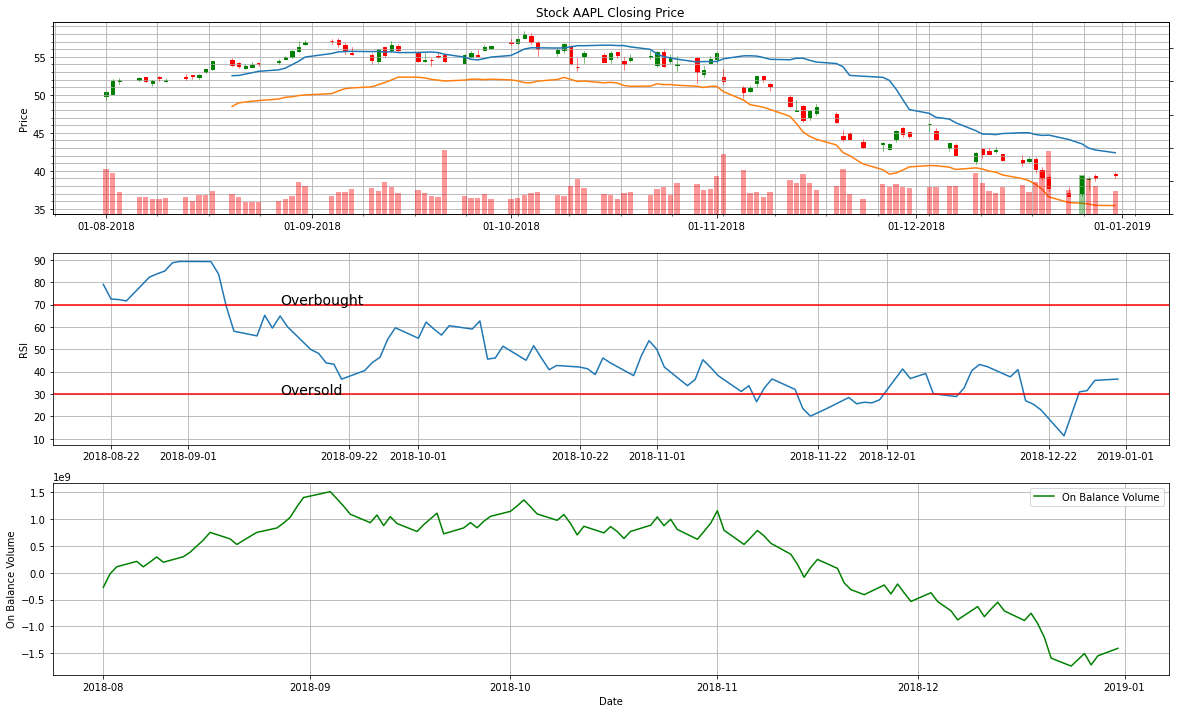

In [6]:
from mplfinance.original_flavor import candlestick_ohlc

fig = plt.figure(figsize=(20,12))
ax1 = plt.subplot(3, 1, 1)
candlestick_ohlc(ax1,dfc.values, width=0.5, colorup='g', colordown='r', alpha=1.0)
ax1.plot(df['Upper Bollinger Band'], label='Upper Bollinger Band')
ax1.plot(df['Lower Bollinger Band'], label='Lower Bollinger Band')
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.grid(True, which='both')
ax1.minorticks_on()
ax1v = ax1.twinx()
colors = dfc.VolumePositive.map({True: 'g', False: 'r'})
ax1v.bar(dfc.Date, dfc['Volume'], color=colors, alpha=0.4)
ax1v.axes.yaxis.set_ticklabels([])
ax1v.set_ylim(0, 3*df.Volume.max())
ax1.set_title('Stock '+ symbol +' Closing Price')
ax1.set_ylabel('Price')

ax2 = plt.subplot(3, 1, 2)
ax2.plot(df['RSI'], label='Relative Strengths Index')
ax2.text(s='Overbought', x=df.RSI.index[30], y=70, fontsize=14)
ax2.text(s='Oversold', x=df.RSI.index[30], y=30, fontsize=14)
ax2.axhline(y=70, color='red')
ax2.axhline(y=30, color='red')
ax2.grid()
ax2.set_ylabel('RSI')

ax3 = plt.subplot(3, 1, 3)
ax3.plot(df['OBV'], label='On Balance Volume', color='green')
ax3.grid()
ax3.set_ylabel('On Balance Volume')
ax3.set_xlabel('Date')
ax3.legend(loc='best')